In [67]:
import os
import glob
import ntpath
import pandas as pd
import numpy as np
import xml.etree.ElementTree
from keras.preprocessing.image import array_to_img, img_to_array, load_img
import pickle
import gc
import progressbar
import time
import logging
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras import layers
from keras.applications import Xception
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt

In [68]:
def plot_acc_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    acc = history.history['acc']
    val_acc = history.history['val_acc']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, acc, 'bo', label='Training loss')
    plt.plot(epochs, val_acc, 'b', label='Validation loss')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [2]:
def exctract_features(model, samples):
    sam_shape = samples.shape
    out_shape = model.output_shape
    new_features = np.zeros(shape=(sam_shape[0],
                            sam_shape[1],
                            out_shape.shape[1],
                            out_shape.shape[2],
                            out_shape.shape[3]),
                           dtype=np.float16)
    
    for i in range(sam_shape[0]):
        new_features[i] = model.predict(samples[i])
    return new_features  

In [3]:
img_in_folder = 10
img_width = 200
img_height = 200
img_channels = 3

def conv_img_to_nparray(img_full_path, img_w, img_h, img_chs=3):
    try:
        img = load_img(img_full_path)
        img = load_img(img_full_path)
        img = img.resize((img_w, img_h))
        x = img_to_array(img)
    except OSError  as ex:
            logging.error(str(ex))
            x = np.zeros(shape=(img_w, img_h, img_chs), dtype=np.float16)
    return x

def load_img_to_array(images_path, labels):
    img_folders_entries = [entry for entry in os.scandir(images_path) if entry.is_dir()]
    entries_count = labels.shape[0]
    dataset = np.ndarray(shape=(entries_count,img_in_folder,
                                                img_height,
                                                img_width,
                                                img_channels),
                                                dtype=np.float16)
    with progressbar.ProgressBar(max_value=entries_count) as bar:
        for i,identifier in enumerate(labels.identifier):
            folder_path = os.path.join(images_path, identifier)
            for j,img_full_path in enumerate(glob.glob(os.path.join(folder_path, '*.jpeg'))):
                dataset[i][j] = conv_img_to_nparray(img_full_path,
                                                             img_width,
                                                             img_height,
                                                             img_channels)
            bar.update(i)

    return dataset

In [4]:
class ImageFeaureExtractor():
    def __init__(self, imgs_in_folder, img_width,
                img_height, img_channels, feature_model):
        self.imgs_in_folder = imgs_in_folder
        self.img_width = img_width
        self.img_height = img_height
        self.img_channels = img_channels
        self.feature_model = feature_model
        
        
    def _exctract_features(self,folder_path):
        folder_images = np.zeros(shape=(self.imgs_in_folder,
                                        self.img_width,
                                        self.img_height,
                                        self.img_channels),
                                        dtype=np.float16)
        for i,img_full_path in enumerate(glob.glob(os.path.join(folder_path, '*.jpeg'))):
                    folder_images[i] = self._conv_img_to_nparray(img_full_path)
        folder_images = folder_images * (1/255)
        return self.feature_model.predict(folder_images)
    
    def _conv_img_to_nparray(self,img_full_path):
        try:
            img = load_img(img_full_path)
            img = load_img(img_full_path)
            img = img.resize((self.img_width, self.img_height))
            x = img_to_array(img)
        except OSError  as ex:
                logging.error(str(ex))
                x = np.zeros(shape=(self.img_width,
                                    self.img_height,
                                    self.img_channels), dtype=np.float16)
        return x
    
    
    def feature_extraction(self, images_path, labels):
        img_folders_entries = [entry for entry in os.scandir(images_path) if entry.is_dir()]
        entries_count = labels.shape[0]
        out_shape = self.feature_model.output_shape
        dataset = np.ndarray(shape=(entries_count,self.imgs_in_folder,
                                                    out_shape[1],
                                                    out_shape[2],
                                                    out_shape[3]),
                                                    dtype=np.float16)
        with progressbar.ProgressBar(max_value=entries_count) as bar:
            for i,identifier in enumerate(labels.identifier):
                folder_path = os.path.join(images_path, identifier)
                dataset[i] = self._exctract_features(folder_path)
                    
                bar.update(i)

        return dataset
        

In [5]:
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [27]:
path_labels_train = r'D:\Machine Learning\Datasets\PAN 18 Author Profiling\pan18-author-profiling-training-2018-02-27\en'

labels_train = pd.read_csv(os.path.join(path_labels_train,'en.txt'),
                     sep=':::',header=None,
                     names=['identifier', 'gender'])

C:\Users\Simeon\Anaconda3\envs\First\lib\site-packages\ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


In [30]:
le = LabelEncoder()
y = le.fit_transform(labels_train.gender)

# Baseline model

In [252]:
path_train = r'D:\Machine Learning\Datasets\PAN 18 Author Profiling\pan18-author-profiling-training-2018-02-27\en\photo'
try_set = labels_train.iloc[np.random.permutation(range(3000))[:1000]]
img_train = load_img_to_array(path_train,try_set)

100% (1000 of 1000) |####################| Elapsed Time: 0:04:11 Time:  0:04:11


In [253]:
y_trunct = try_set.gender[:1000]

In [254]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_trunct = le.fit_transform(y_trunct)

In [ ]:
img_train = img_train * (1/255)

In [255]:
gc.collect()

10546

In [256]:
model = Sequential()
model.add(layers.TimeDistributed(layers.Conv2D(16,(3,3),
                                               activation='relu'),
                                input_shape=((img_in_folder,
                                            img_width,
                                            img_height,
                                            img_channels))))
model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
model.add(layers.TimeDistributed(layers.Conv2D(24,(3,3),
                                               activation='relu')))
model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
model.add(layers.TimeDistributed(layers.Conv2D(32,(3,3),
                                               activation='relu')))
model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
model.add(layers.TimeDistributed(layers.Conv2D(32,(3,3),
                                               activation='relu')))
model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
model.add(layers.TimeDistributed(Flatten()))
model.add(layers.LSTM(16, return_sequences=False))
model.add(layers.Dense(1, activation='sigmoid'))

In [257]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])

In [258]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_84 (TimeDis (None, 10, 198, 198, 16)  448       
_________________________________________________________________
time_distributed_85 (TimeDis (None, 10, 99, 99, 16)    0         
_________________________________________________________________
time_distributed_86 (TimeDis (None, 10, 97, 97, 24)    3480      
_________________________________________________________________
time_distributed_87 (TimeDis (None, 10, 48, 48, 24)    0         
_________________________________________________________________
time_distributed_88 (TimeDis (None, 10, 46, 46, 32)    6944      
_________________________________________________________________
time_distributed_89 (TimeDis (None, 10, 23, 23, 32)    0         
_________________________________________________________________
time_distributed_90 (TimeDis (None, 10, 21, 21, 32)    9248      
__________

In [312]:
history = model.fit(img_train[:800], y_trunct[:800],
                    epochs=10,
                    batch_size=8,
                    validation_split=0.1)

Train on 720 samples, validate on 80 samples
Epoch 1/10
720/720 [==============================] - 16s 22ms/step - loss: 0.7069 - acc: 0.4833 - val_loss: 0.7129 - val_acc: 0.5250
Epoch 2/10
720/720 [==============================] - 15s 21ms/step - loss: 0.6986 - acc: 0.4944 - val_loss: 0.6939 - val_acc: 0.5000
Epoch 3/10
720/720 [==============================] - 15s 21ms/step - loss: 0.6955 - acc: 0.4778 - val_loss: 0.6942 - val_acc: 0.4750
Epoch 4/10
720/720 [==============================] - 15s 21ms/step - loss: 0.6965 - acc: 0.4722 - val_loss: 0.6939 - val_acc: 0.5000
Epoch 5/10
720/720 [==============================] - 15s 21ms/step - loss: 0.6967 - acc: 0.5069 - val_loss: 0.6921 - val_acc: 0.5250
Epoch 6/10
720/720 [==============================] - 15s 21ms/step - loss: 0.6947 - acc: 0.5014 - val_loss: 0.6930 - val_acc: 0.5250
Epoch 7/10
720/720 [==============================] - 15s 21ms/step - loss: 0.6971 - acc: 0.4847 - val_loss: 0.6913 - val_acc: 0.5250
Epoch 8/10
720/72

In [261]:
pr = model.predict_classes(img_train[800:])

In [262]:
accuracy_score(pr, y_trunct[800:])

0.445

In [313]:
(img_train.size*img_train.itemsize) / (1024*1024)

2288.818359375

In [314]:
del img_train

In [315]:
gc.collect()

47

# Use pretrained CNN model

In [ ]:
conv_base.out

In [10]:
conv_base = Xception(weights='imagenet',
                    include_top=False,
                    input_shape=(200, 200, 3))

In [11]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 99, 99, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 99, 99, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [11]:
img_feat_extractor = ImageFeaureExtractor(img_in_folder,
                                            img_width,
                                            img_height,
                                            img_channels,
                                             conv_base)

In [13]:
images_path_train = r'D:\Machine Learning\Datasets\PAN 18 Author Profiling\pan18-author-profiling-training-2018-02-27\en\photo'
extracted_features = img_feat_extractor.feature_extraction(images_path_train,labels_train)

 11% (333 of 3000) |##                   | Elapsed Time: 0:02:15 ETA:   0:17:50ERROR:root:cannot identify image file 'D:\\Machine Learning\\Datasets\\PAN 18 Author Profiling\\pan18-author-profiling-training-2018-02-27\\en\\photo\\cbc0e7675ce123b7ca31f127dc7aeff5\\cbc0e7675ce123b7ca31f127dc7aeff5.6.jpeg'
ERROR:root:cannot identify image file 'D:\\Machine Learning\\Datasets\\PAN 18 Author Profiling\\pan18-author-profiling-training-2018-02-27\\en\\photo\\cbc0e7675ce123b7ca31f127dc7aeff5\\cbc0e7675ce123b7ca31f127dc7aeff5.7.jpeg'
ERROR:root:cannot identify image file 'D:\\Machine Learning\\Datasets\\PAN 18 Author Profiling\\pan18-author-profiling-training-2018-02-27\\en\\photo\\cbc0e7675ce123b7ca31f127dc7aeff5\\cbc0e7675ce123b7ca31f127dc7aeff5.8.jpeg'
ERROR:root:cannot identify image file 'D:\\Machine Learning\\Datasets\\PAN 18 Author Profiling\\pan18-author-profiling-training-2018-02-27\\en\\photo\\cbc0e7675ce123b7ca31f127dc7aeff5\\cbc0e7675ce123b7ca31f127dc7aeff5.9.jpeg'
 27% (813 of 3000

In [18]:
gc.collect()

83050

In [16]:
extracted_features.size * extracted_features.itemsize / (1024**2)

5742.1875

In [45]:
extracted_features.shape

(3000, 10, 7, 7, 2048)

In [76]:
extracted_features = extracted_features.reshape(3000, 10, -1)
extracted_features.shape

(3000, 10, 100352)

In [57]:
output_shape = conv_base.output_shape

In [84]:
model = Sequential()
model.add(layers.TimeDistributed(layers.Dropout(rate=0.2),
                                            input_shape=((img_in_folder,
                                                          extracted_features.shape[-1]))))
model.add(layers.TimeDistributed(layers.Dense(10, activation='relu')))
model.add(layers.GRU(16, return_sequences=True))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1, activation='sigmoid'))

In [85]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])

In [86]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_28 (TimeDis (None, 10, 100352)        0         
_________________________________________________________________
time_distributed_29 (TimeDis (None, 10, 10)            1003530   
_________________________________________________________________
gru_15 (GRU)                 (None, 10, 16)            1296      
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 16)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 17        
Total params: 1,004,843
Trainable params: 1,004,843
Non-trainable params: 0
_________________________________________________________________


In [87]:
history = model.fit(extracted_features, y,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.1)

Train on 2700 samples, validate on 300 samples
Epoch 1/50
2700/2700 [==============================] - 30s 11ms/step - loss: 0.6994 - acc: 0.5256 - val_loss: 0.7859 - val_acc: 0.3000
Epoch 2/50
2700/2700 [==============================] - 27s 10ms/step - loss: 0.6737 - acc: 0.5841 - val_loss: 0.8489 - val_acc: 0.2667
Epoch 3/50
2700/2700 [==============================] - 28s 10ms/step - loss: 0.6294 - acc: 0.6648 - val_loss: 0.6877 - val_acc: 0.5833
Epoch 4/50
2700/2700 [==============================] - 27s 10ms/step - loss: 0.5978 - acc: 0.7085 - val_loss: 0.9480 - val_acc: 0.2400
Epoch 5/50
2700/2700 [==============================] - 27s 10ms/step - loss: 0.5743 - acc: 0.7322 - val_loss: 0.6143 - val_acc: 0.6667
Epoch 6/50
2700/2700 [==============================] - 27s 10ms/step - loss: 0.5487 - acc: 0.7581 - val_loss: 0.5181 - val_acc: 0.8100
Epoch 7/50
2700/2700 [==============================] - 27s 10ms/step - loss: 0.5212 - acc: 0.7685 - val_loss: 0.5937 - val_acc: 0.6867
E

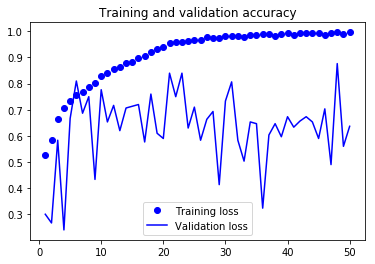

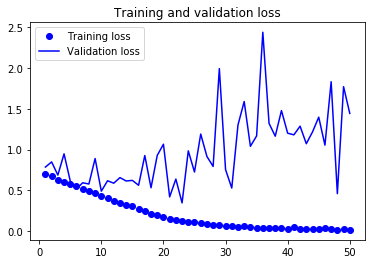

In [90]:
plot_acc_loss(history)

In [92]:
model = Sequential()
model.add(layers.TimeDistributed(layers.Dropout(rate=0.3),
                                            input_shape=((img_in_folder,
                                                          extracted_features.shape[-1]))))
model.add(layers.TimeDistributed(layers.Dense(10, activation='relu')))
model.add(layers.GRU(16, return_sequences=True, dropout=0.3))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1, activation='sigmoid'))

In [99]:
model.compile(optimizer=RMSprop(lr=0.001),
             loss='binary_crossentropy',
             metrics=['acc'])

In [100]:
history = model.fit(extracted_features, y,
                    epochs=30,
                    batch_size=128,
                    validation_split=0.1)

Train on 2700 samples, validate on 300 samples
Epoch 1/30
2700/2700 [==============================] - 29s 11ms/step - loss: 0.3397 - acc: 0.8781 - val_loss: 0.7391 - val_acc: 0.7333
Epoch 2/30
2700/2700 [==============================] - 28s 10ms/step - loss: 0.3075 - acc: 0.8952 - val_loss: 0.9211 - val_acc: 0.6600
Epoch 3/30
2700/2700 [==============================] - 28s 10ms/step - loss: 0.2915 - acc: 0.9000 - val_loss: 0.6600 - val_acc: 0.7500
Epoch 4/30
2700/2700 [==============================] - 27s 10ms/step - loss: 0.2776 - acc: 0.9093 - val_loss: 1.2438 - val_acc: 0.5733
Epoch 5/30
2700/2700 [==============================] - 28s 10ms/step - loss: 0.2854 - acc: 0.9048 - val_loss: 0.6982 - val_acc: 0.7633
Epoch 6/30
2700/2700 [==============================] - 27s 10ms/step - loss: 0.2808 - acc: 0.9096 - val_loss: 0.4103 - val_acc: 0.8600
Epoch 7/30
2700/2700 [==============================] - 27s 10ms/step - loss: 0.2668 - acc: 0.9107 - val_loss: 0.8288 - val_acc: 0.7167
E

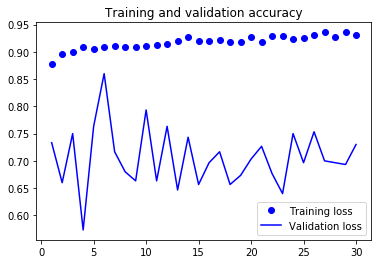

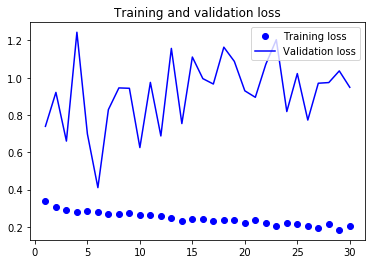

In [102]:
plot_acc_loss(history)

In [110]:
model = Sequential()
model.add(layers.TimeDistributed(layers.Dropout(rate=0.35),
                                            input_shape=((img_in_folder,
                                                          extracted_features.shape[-1]))))
model.add(layers.TimeDistributed(layers.Dense(10, activation='relu')))
model.add(layers.GRU(16, return_sequences=True, dropout=0.35))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(lr=0.00001),
             loss='binary_crossentropy',
             metrics=['acc'])

In [111]:
history = model.fit(extracted_features, y,
                    epochs=30,
                    batch_size=200,
                    validation_split=0.1)

Train on 2700 samples, validate on 300 samples
Epoch 1/30
2700/2700 [==============================] - 30s 11ms/step - loss: 0.6960 - acc: 0.5204 - val_loss: 0.7618 - val_acc: 0.1100
Epoch 2/30
2700/2700 [==============================] - 27s 10ms/step - loss: 0.6837 - acc: 0.5500 - val_loss: 0.7426 - val_acc: 0.2167
Epoch 3/30
2700/2700 [==============================] - 28s 10ms/step - loss: 0.6758 - acc: 0.5733 - val_loss: 0.7558 - val_acc: 0.1967
Epoch 4/30
2700/2700 [==============================] - 27s 10ms/step - loss: 0.6666 - acc: 0.5841 - val_loss: 0.7999 - val_acc: 0.1167
Epoch 5/30
2700/2700 [==============================] - 27s 10ms/step - loss: 0.6565 - acc: 0.5981 - val_loss: 0.7922 - val_acc: 0.1800
Epoch 6/30
2700/2700 [==============================] - 27s 10ms/step - loss: 0.6509 - acc: 0.6044 - val_loss: 0.6544 - val_acc: 0.6967
Epoch 7/30
2700/2700 [==============================] - 29s 11ms/step - loss: 0.6399 - acc: 0.6204 - val_loss: 0.6670 - val_acc: 0.6667
E

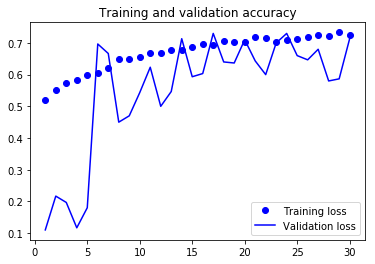

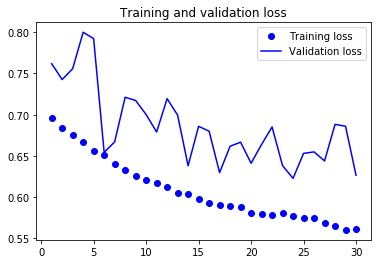

In [112]:
plot_acc_loss(history)

In [114]:
model = Sequential()
model.add(layers.TimeDistributed(layers.Dropout(rate=0.35),
                                            input_shape=((img_in_folder,
                                                          extracted_features.shape[-1]))))
model.add(layers.TimeDistributed(layers.Dense(10, activation='relu')))
model.add(layers.TimeDistributed(layers.Dropout(rate=0.2)))
model.add(layers.GRU(16, return_sequences=False, dropout=0.35))
#model.add(layers.GlobalMaxPooling1D())
#model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(lr=0.0001),
             loss='binary_crossentropy',
             metrics=['acc'])

In [115]:
history = model.fit(extracted_features, y,
                    epochs=30,
                    batch_size=200,
                    validation_split=0.1)

Train on 2700 samples, validate on 300 samples
Epoch 1/30
2700/2700 [==============================] - 31s 11ms/step - loss: 0.7001 - acc: 0.5474 - val_loss: 0.7048 - val_acc: 0.4333
Epoch 2/30
2700/2700 [==============================] - 29s 11ms/step - loss: 0.6690 - acc: 0.5763 - val_loss: 0.8472 - val_acc: 0.1600
Epoch 3/30
2700/2700 [==============================] - 24s 9ms/step - loss: 0.6548 - acc: 0.6011 - val_loss: 0.8134 - val_acc: 0.1900
Epoch 4/30
2700/2700 [==============================] - 24s 9ms/step - loss: 0.6474 - acc: 0.6052 - val_loss: 0.7966 - val_acc: 0.2800
Epoch 5/30
2700/2700 [==============================] - 28s 10ms/step - loss: 0.6435 - acc: 0.6219 - val_loss: 0.7361 - val_acc: 0.4767
Epoch 6/30
2700/2700 [==============================] - 27s 10ms/step - loss: 0.6328 - acc: 0.6467 - val_loss: 1.1110 - val_acc: 0.1067
Epoch 7/30
2700/2700 [==============================] - 25s 9ms/step - loss: 0.6218 - acc: 0.6507 - val_loss: 0.6455 - val_acc: 0.7300
Epoc

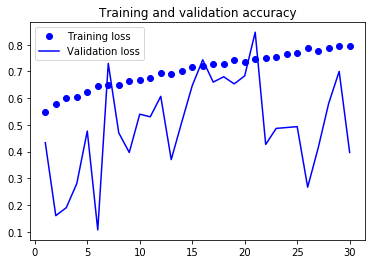

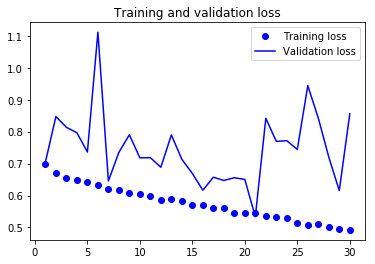

In [116]:
plot_acc_loss(history)

# Trying with pretrained MobileNetV2

In [24]:
from keras.applications import MobileNetV2
mobileNetV2_base = MobileNetV2(weights='imagenet',
                    include_top=False,
                    input_shape=(192, 192, 3))
mobileNetV2_base.output_shape

(None, 6, 6, 1280)

In [26]:
img_feat_extractor_mobilenet = ImageFeaureExtractor(10,
                                            192,
                                            192,
                                            3,
                                             mobileNetV2_base)

In [28]:
images_path_train = r'D:\Machine Learning\Datasets\PAN 18 Author Profiling\pan18-author-profiling-training-2018-02-27\en\photo'
mobnet2_feats = img_feat_extractor_mobilenet.feature_extraction(images_path_train,labels_train)

 11% (333 of 3000) |##                   | Elapsed Time: 0:02:09 ETA:   0:19:13ERROR:root:cannot identify image file 'D:\\Machine Learning\\Datasets\\PAN 18 Author Profiling\\pan18-author-profiling-training-2018-02-27\\en\\photo\\cbc0e7675ce123b7ca31f127dc7aeff5\\cbc0e7675ce123b7ca31f127dc7aeff5.6.jpeg'
ERROR:root:cannot identify image file 'D:\\Machine Learning\\Datasets\\PAN 18 Author Profiling\\pan18-author-profiling-training-2018-02-27\\en\\photo\\cbc0e7675ce123b7ca31f127dc7aeff5\\cbc0e7675ce123b7ca31f127dc7aeff5.7.jpeg'
ERROR:root:cannot identify image file 'D:\\Machine Learning\\Datasets\\PAN 18 Author Profiling\\pan18-author-profiling-training-2018-02-27\\en\\photo\\cbc0e7675ce123b7ca31f127dc7aeff5\\cbc0e7675ce123b7ca31f127dc7aeff5.8.jpeg'
ERROR:root:cannot identify image file 'D:\\Machine Learning\\Datasets\\PAN 18 Author Profiling\\pan18-author-profiling-training-2018-02-27\\en\\photo\\cbc0e7675ce123b7ca31f127dc7aeff5\\cbc0e7675ce123b7ca31f127dc7aeff5.9.jpeg'
 27% (813 of 3000

In [32]:
mobnet2_feats.shape

(3000, 10, 6, 6, 1280)

In [33]:
mobnet2_feats = mobnet2_feats.reshape(3000,10,-1)
mobnet2_feats.shape

(3000, 10, 46080)

In [34]:
model = Sequential()
model.add(layers.TimeDistributed(layers.Dropout(rate=0.3),
                                            input_shape=((img_in_folder,
                                                          mobnet2_feats.shape[-1]))))
model.add(layers.TimeDistributed(layers.Dense(10, activation='relu')))
model.add(layers.GRU(16, return_sequences=True, dropout=0.3))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=RMSprop(lr=0.001),
             loss='binary_crossentropy',
             metrics=['acc'])

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 10, 46080)         0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 10)            460810    
_________________________________________________________________
gru_1 (GRU)                  (None, 10, 16)            1296      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 462,123
Trainable params: 462,123
Non-trainable params: 0
_________________________________________________________________


In [36]:
history = model.fit(mobnet2_feats, y,
                    epochs=30,
                    batch_size=128,
                    validation_split=0.1)

Train on 2700 samples, validate on 300 samples
Epoch 1/30
2700/2700 [==============================] - 16s 6ms/step - loss: 0.7380 - acc: 0.5367 - val_loss: 0.5772 - val_acc: 0.9867
Epoch 2/30
2700/2700 [==============================] - 12s 4ms/step - loss: 0.6886 - acc: 0.5685 - val_loss: 1.1394 - val_acc: 0.1033
Epoch 3/30
2700/2700 [==============================] - 11s 4ms/step - loss: 0.6762 - acc: 0.5826 - val_loss: 0.5616 - val_acc: 0.8267
Epoch 4/30
2700/2700 [==============================] - 12s 4ms/step - loss: 0.6383 - acc: 0.6348 - val_loss: 0.9547 - val_acc: 0.2767
Epoch 5/30
2700/2700 [==============================] - 12s 4ms/step - loss: 0.6295 - acc: 0.6389 - val_loss: 0.7672 - val_acc: 0.4933
Epoch 6/30
2700/2700 [==============================] - 11s 4ms/step - loss: 0.6024 - acc: 0.6756 - val_loss: 0.5740 - val_acc: 0.7467
Epoch 7/30
2700/2700 [==============================] - 12s 4ms/step - loss: 0.5867 - acc: 0.6952 - val_loss: 0.5940 - val_acc: 0.7200
Epoch 8/

In [58]:
model = Sequential()
model.add(layers.TimeDistributed(layers.Dense(10, activation='relu'),
                                            input_shape=((img_in_folder,
                                                          mobnet2_feats.shape[-1]))))
model.add(layers.Conv1D(32, kernel_size=(10)))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=RMSprop(lr=0.001),
             loss='binary_crossentropy',
             metrics=['acc'])

In [59]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_26 (TimeDis (None, 10, 10)            460810    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1, 32)             3232      
_________________________________________________________________
flatten_3 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 33        
Total params: 464,075
Trainable params: 464,075
Non-trainable params: 0
_________________________________________________________________


In [60]:
history = model.fit(mobnet2_feats, y,
                    epochs=30,
                    batch_size=256,
                    validation_split=0.1)

Train on 2700 samples, validate on 300 samples
Epoch 1/30
2700/2700 [==============================] - 15s 6ms/step - loss: 6.6287 - acc: 0.5441 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 2/30
2700/2700 [==============================] - 12s 4ms/step - loss: 7.1636 - acc: 0.5556 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 3/30
2700/2700 [==============================] - 12s 4ms/step - loss: 7.1636 - acc: 0.5556 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 4/30
2700/2700 [==============================] - 12s 4ms/step - loss: 7.1636 - acc: 0.5556 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 5/30
 256/2700 [=>............................] - ETA: 8s - loss: 7.3665 - acc: 0.5430

KeyboardInterrupt: 

In [64]:
model = Sequential()
model.add(layers.TimeDistributed(layers.Dense(10, activation='relu'),
                                            input_shape=((img_in_folder,
                                                          mobnet2_feats.shape[-1]))))
model.add(layers.TimeDistributed(layers.Dropout(rate=0.3)))
model.add(layers.TimeDistributed(layers.Dense(6, activation='relu')))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dropout(rate=0.1))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=RMSprop(lr=0.001),
             loss='binary_crossentropy',
             metrics=['acc'])

In [65]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_34 (TimeDis (None, 10, 10)            460810    
_________________________________________________________________
time_distributed_35 (TimeDis (None, 10, 10)            0         
_________________________________________________________________
time_distributed_36 (TimeDis (None, 10, 6)             66        
_________________________________________________________________
global_average_pooling1d_5 ( (None, 6)                 0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 7         
Total params: 460,883
Trainable params: 460,883
Non-trainable params: 0
_________________________________________________________________


In [66]:
history = model.fit(mobnet2_feats, y,
                    epochs=30,
                    batch_size=270,
                    validation_split=0.1)

Train on 2700 samples, validate on 300 samples
Epoch 1/30
2700/2700 [==============================] - 15s 6ms/step - loss: 1.0207 - acc: 0.4981 - val_loss: 0.4383 - val_acc: 1.0000
Epoch 2/30
2700/2700 [==============================] - 12s 4ms/step - loss: 0.6913 - acc: 0.5385 - val_loss: 0.6196 - val_acc: 0.9733
Epoch 3/30
2700/2700 [==============================] - 11s 4ms/step - loss: 0.6489 - acc: 0.5993 - val_loss: 0.6917 - val_acc: 0.7533
Epoch 4/30
2700/2700 [==============================] - 11s 4ms/step - loss: 0.6334 - acc: 0.6230 - val_loss: 0.6808 - val_acc: 0.7700
Epoch 5/30
2700/2700 [==============================] - 11s 4ms/step - loss: 0.6253 - acc: 0.6330 - val_loss: 0.9000 - val_acc: 0.3600
Epoch 6/30
2700/2700 [==============================] - 11s 4ms/step - loss: 0.6249 - acc: 0.6367 - val_loss: 0.6584 - val_acc: 0.8400
Epoch 7/30
2700/2700 [==============================] - 11s 4ms/step - loss: 0.5907 - acc: 0.6707 - val_loss: 0.7046 - val_acc: 0.7200
Epoch 8/

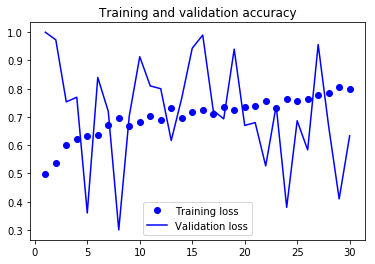

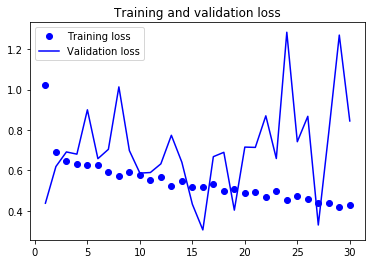

In [69]:
plot_acc_loss(history)

# Try VGG

In [76]:
from keras.applications import VGG19
VGG19_base = VGG16(weights='imagenet',
                    include_top=False,
                    input_shape=(200, 200, 3))
VGG19_base.output_shape

(None, 6, 6, 512)

In [77]:
img_feat_extractor_VGG19 = ImageFeaureExtractor(10,
                                            200,
                                            200,
                                            3,
                                             VGG19_base)
images_path_train = r'D:\Machine Learning\Datasets\PAN 18 Author Profiling\pan18-author-profiling-training-2018-02-27\en\photo'
vgg19_feats = img_feat_extractor_VGG19.feature_extraction(images_path_train,labels_train)

 11% (333 of 3000) |##                   | Elapsed Time: 0:01:46 ETA:   0:15:49ERROR:root:cannot identify image file 'D:\\Machine Learning\\Datasets\\PAN 18 Author Profiling\\pan18-author-profiling-training-2018-02-27\\en\\photo\\cbc0e7675ce123b7ca31f127dc7aeff5\\cbc0e7675ce123b7ca31f127dc7aeff5.6.jpeg'
ERROR:root:cannot identify image file 'D:\\Machine Learning\\Datasets\\PAN 18 Author Profiling\\pan18-author-profiling-training-2018-02-27\\en\\photo\\cbc0e7675ce123b7ca31f127dc7aeff5\\cbc0e7675ce123b7ca31f127dc7aeff5.7.jpeg'
ERROR:root:cannot identify image file 'D:\\Machine Learning\\Datasets\\PAN 18 Author Profiling\\pan18-author-profiling-training-2018-02-27\\en\\photo\\cbc0e7675ce123b7ca31f127dc7aeff5\\cbc0e7675ce123b7ca31f127dc7aeff5.8.jpeg'
ERROR:root:cannot identify image file 'D:\\Machine Learning\\Datasets\\PAN 18 Author Profiling\\pan18-author-profiling-training-2018-02-27\\en\\photo\\cbc0e7675ce123b7ca31f127dc7aeff5\\cbc0e7675ce123b7ca31f127dc7aeff5.9.jpeg'
 27% (813 of 3000

In [78]:
vgg19_feats.shape

(3000, 10, 6, 6, 512)

In [79]:
vgg19_feats = vgg19_feats.reshape(3000, 10, -1)

In [80]:
vgg19_feats.shape

(3000, 10, 18432)

In [82]:
model = Sequential()
model.add(layers.TimeDistributed(layers.Dropout(rate=0.3),
                                            input_shape=((img_in_folder,
                                                          vgg19_feats.shape[-1]))))
model.add(layers.TimeDistributed(layers.Dense(10, activation='relu')))
model.add(layers.GRU(16, return_sequences=True, dropout=0.3))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=RMSprop(lr=0.001),
             loss='binary_crossentropy',
             metrics=['acc'])

In [83]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_37 (TimeDis (None, 10, 18432)         0         
_________________________________________________________________
time_distributed_38 (TimeDis (None, 10, 10)            184330    
_________________________________________________________________
gru_2 (GRU)                  (None, 10, 16)            1296      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 17        
Total params: 185,643
Trainable params: 185,643
Non-trainable params: 0
_________________________________________________________________


In [84]:
history = model.fit(vgg19_feats, y,
                    epochs=30,
                    batch_size=270,
                    validation_split=0.1)

Train on 2700 samples, validate on 300 samples
Epoch 1/30
2700/2700 [==============================] - 11s 4ms/step - loss: 0.6981 - acc: 0.5504 - val_loss: 0.6823 - val_acc: 0.6967
Epoch 2/30
2700/2700 [==============================] - 5s 2ms/step - loss: 0.6813 - acc: 0.5485 - val_loss: 0.7892 - val_acc: 0.0000e+00
Epoch 3/30
2700/2700 [==============================] - 6s 2ms/step - loss: 0.6816 - acc: 0.5667 - val_loss: 0.7472 - val_acc: 0.0500
Epoch 4/30
2700/2700 [==============================] - 6s 2ms/step - loss: 0.6638 - acc: 0.5704 - val_loss: 0.8460 - val_acc: 0.0000e+00
Epoch 5/30
2700/2700 [==============================] - 5s 2ms/step - loss: 0.6570 - acc: 0.5811 - val_loss: 0.7880 - val_acc: 0.2233
Epoch 6/30
2700/2700 [==============================] - 5s 2ms/step - loss: 0.6507 - acc: 0.5941 - val_loss: 0.8995 - val_acc: 0.0200
Epoch 7/30
2700/2700 [==============================] - 5s 2ms/step - loss: 0.6425 - acc: 0.6000 - val_loss: 0.8462 - val_acc: 0.1633
Epoch 

In [88]:
model = Sequential()
model.add(layers.TimeDistributed(layers.Dense(10, activation='relu'),
                                            input_shape=((img_in_folder,
                                                          vgg19_feats.shape[-1]))))
model.add(layers.TimeDistributed(layers.Dropout(rate=0.3)))
model.add(layers.TimeDistributed(layers.Dense(10, activation='relu')))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=RMSprop(lr=0.001),
             loss='binary_crossentropy',
             metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_43 (TimeDis (None, 10, 10)            184330    
_________________________________________________________________
time_distributed_44 (TimeDis (None, 10, 10)            0         
_________________________________________________________________
time_distributed_45 (TimeDis (None, 10, 10)            110       
_________________________________________________________________
global_average_pooling1d_8 ( (None, 10)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 11        
Total params: 184,451
Trainable params: 184,451
Non-trainable params: 0
_________________________________________________________________


In [91]:
history = model.fit(vgg19_feats, y,
                    epochs=50,
                    batch_size=135,
                    validation_split=0.1)

Train on 2700 samples, validate on 300 samples
Epoch 1/50
2700/2700 [==============================] - 5s 2ms/step - loss: 0.5472 - acc: 0.7081 - val_loss: 0.8499 - val_acc: 0.4500
Epoch 2/50
2700/2700 [==============================] - 5s 2ms/step - loss: 0.5127 - acc: 0.7570 - val_loss: 1.0838 - val_acc: 0.3033
Epoch 3/50
2700/2700 [==============================] - 5s 2ms/step - loss: 0.5208 - acc: 0.7470 - val_loss: 0.9337 - val_acc: 0.4133
Epoch 4/50
2700/2700 [==============================] - 5s 2ms/step - loss: 0.5128 - acc: 0.7511 - val_loss: 1.0077 - val_acc: 0.3033
Epoch 5/50
2700/2700 [==============================] - 5s 2ms/step - loss: 0.4976 - acc: 0.7596 - val_loss: 1.2067 - val_acc: 0.2667
Epoch 6/50
2700/2700 [==============================] - 5s 2ms/step - loss: 0.5045 - acc: 0.7622 - val_loss: 0.7045 - val_acc: 0.6600
Epoch 7/50
2700/2700 [==============================] - 5s 2ms/step - loss: 0.5000 - acc: 0.7578 - val_loss: 0.6629 - val_acc: 0.6767
Epoch 8/50
2700

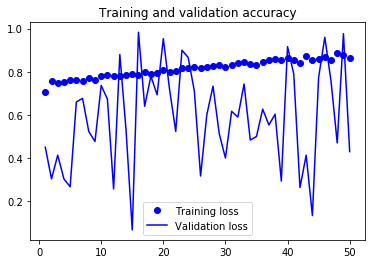

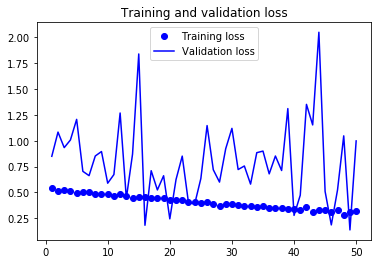

In [92]:
plot_acc_loss(history)

In [93]:
model = Sequential()
model.add(layers.TimeDistributed(layers.Dropout(rate=0.3),
                                            input_shape=((img_in_folder,
                                                          vgg19_feats.shape[-1]))))
model.add(layers.TimeDistributed(layers.Dense(10, activation='relu')))
model.add(layers.GRU(16, return_sequences=True, dropout=0.3))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=RMSprop(lr=0.001),
             loss='binary_crossentropy',
             metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_46 (TimeDis (None, 10, 18432)         0         
_________________________________________________________________
time_distributed_47 (TimeDis (None, 10, 10)            184330    
_________________________________________________________________
gru_4 (GRU)                  (None, 10, 16)            1296      
_________________________________________________________________
global_average_pooling1d_9 ( (None, 16)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 17        
Total params: 185,643
Trainable params: 185,643
Non-trainable params: 0
_________________________________________________________________


In [94]:
history = model.fit(vgg19_feats, y,
                    epochs=50,
                    batch_size=135,
                    validation_split=0.1)

Train on 2700 samples, validate on 300 samples
Epoch 1/50
2700/2700 [==============================] - 39s 14ms/step - loss: 0.7689 - acc: 0.5559 - val_loss: 1.0448 - val_acc: 0.0000e+00
Epoch 2/50
2700/2700 [==============================] - 6s 2ms/step - loss: 0.7227 - acc: 0.5456 - val_loss: 0.9105 - val_acc: 0.0000e+00
Epoch 3/50
2700/2700 [==============================] - 6s 2ms/step - loss: 0.7061 - acc: 0.5374 - val_loss: 0.9577 - val_acc: 0.0000e+00
Epoch 4/50
2700/2700 [==============================] - 6s 2ms/step - loss: 0.6966 - acc: 0.5422 - val_loss: 0.8034 - val_acc: 0.0000e+00
Epoch 5/50
2700/2700 [==============================] - 6s 2ms/step - loss: 0.6888 - acc: 0.5589 - val_loss: 0.8580 - val_acc: 0.0000e+00
Epoch 6/50
2700/2700 [==============================] - 6s 2ms/step - loss: 0.6828 - acc: 0.5563 - val_loss: 0.8793 - val_acc: 0.0067
Epoch 7/50
2700/2700 [==============================] - 6s 2ms/step - loss: 0.6818 - acc: 0.5637 - val_loss: 0.7706 - val_acc: 

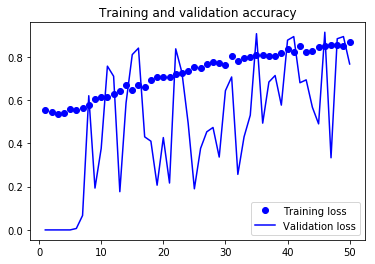

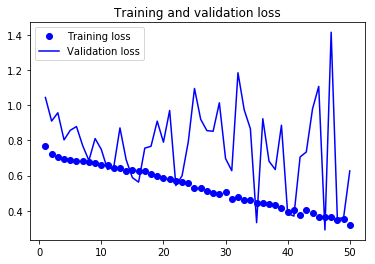

In [95]:
plot_acc_loss(history)

In [119]:
model = Sequential()
model.add(layers.TimeDistributed(layers.Dropout(rate=0.2),
                                            input_shape=((img_in_folder,
                                                          vgg19_feats.shape[-1]))))
model.add(layers.TimeDistributed(layers.Dense(4, activation='relu')))
model.add(layers.GRU(6, return_sequences=True, dropout=0.2))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=RMSprop(lr=0.0001),
             loss='binary_crossentropy',
             metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_66 (TimeDis (None, 10, 18432)         0         
_________________________________________________________________
time_distributed_67 (TimeDis (None, 10, 4)             73732     
_________________________________________________________________
gru_13 (GRU)                 (None, 10, 6)             198       
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 6)                 0         
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 7         
Total params: 73,937
Trainable params: 73,937
Non-trainable params: 0
_________________________________________________________________


In [121]:
history = model.fit(vgg19_feats, y,
                    epochs=150,
                    batch_size=135,
                    validation_split=0.1)

Train on 2700 samples, validate on 300 samples
Epoch 1/150
2700/2700 [==============================] - 13s 5ms/step - loss: 0.6892 - acc: 0.5511 - val_loss: 0.8981 - val_acc: 0.0000e+00
Epoch 2/150
2700/2700 [==============================] - 6s 2ms/step - loss: 0.6837 - acc: 0.5663 - val_loss: 0.8918 - val_acc: 0.0000e+00
Epoch 3/150
2700/2700 [==============================] - 6s 2ms/step - loss: 0.6847 - acc: 0.5622 - val_loss: 0.7578 - val_acc: 0.2033
Epoch 4/150
2700/2700 [==============================] - 5s 2ms/step - loss: 0.6803 - acc: 0.5678 - val_loss: 0.7786 - val_acc: 0.1033
Epoch 5/150
2700/2700 [==============================] - 5s 2ms/step - loss: 0.6804 - acc: 0.5570 - val_loss: 0.8024 - val_acc: 0.0567
Epoch 6/150
2700/2700 [==============================] - 5s 2ms/step - loss: 0.6776 - acc: 0.5730 - val_loss: 0.7939 - val_acc: 0.1533
Epoch 7/150
2700/2700 [==============================] - 5s 2ms/step - loss: 0.6775 - acc: 0.5681 - val_loss: 0.8617 - val_acc: 0.0367

Epoch 61/150
2700/2700 [==============================] - 5s 2ms/step - loss: 0.5239 - acc: 0.7781 - val_loss: 0.7363 - val_acc: 0.5667
Epoch 62/150
2700/2700 [==============================] - 5s 2ms/step - loss: 0.5237 - acc: 0.7819 - val_loss: 0.8364 - val_acc: 0.3933
Epoch 63/150
2700/2700 [==============================] - 5s 2ms/step - loss: 0.5220 - acc: 0.7770 - val_loss: 0.7152 - val_acc: 0.6100
Epoch 64/150
2700/2700 [==============================] - 5s 2ms/step - loss: 0.5169 - acc: 0.7867 - val_loss: 0.7613 - val_acc: 0.5300
Epoch 65/150
2700/2700 [==============================] - 5s 2ms/step - loss: 0.5162 - acc: 0.7822 - val_loss: 0.7912 - val_acc: 0.5000
Epoch 66/150
2700/2700 [==============================] - 5s 2ms/step - loss: 0.5177 - acc: 0.7804 - val_loss: 0.7542 - val_acc: 0.5567
Epoch 67/150
2700/2700 [==============================] - 5s 2ms/step - loss: 0.5074 - acc: 0.7919 - val_loss: 0.7030 - val_acc: 0.6333
Epoch 68/150
2700/2700 [========================

2700/2700 [==============================] - 6s 2ms/step - loss: 0.3678 - acc: 0.8841 - val_loss: 0.7578 - val_acc: 0.6033
Epoch 122/150
2700/2700 [==============================] - 5s 2ms/step - loss: 0.3675 - acc: 0.8822 - val_loss: 0.4608 - val_acc: 0.8300
Epoch 123/150
2700/2700 [==============================] - 6s 2ms/step - loss: 0.3681 - acc: 0.8767 - val_loss: 0.6630 - val_acc: 0.6733
Epoch 124/150
2700/2700 [==============================] - 6s 2ms/step - loss: 0.3647 - acc: 0.8863 - val_loss: 0.6720 - val_acc: 0.6767
Epoch 125/150
2700/2700 [==============================] - 5s 2ms/step - loss: 0.3523 - acc: 0.8948 - val_loss: 0.9256 - val_acc: 0.4633
Epoch 126/150
2700/2700 [==============================] - 5s 2ms/step - loss: 0.3600 - acc: 0.8863 - val_loss: 0.5536 - val_acc: 0.7567
Epoch 127/150
2700/2700 [==============================] - 6s 2ms/step - loss: 0.3635 - acc: 0.8756 - val_loss: 0.8223 - val_acc: 0.5367
Epoch 128/150
2700/2700 [==============================

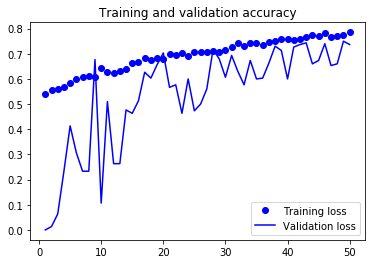

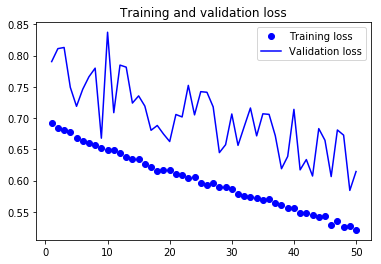

In [118]:
plot_acc_loss(history50)

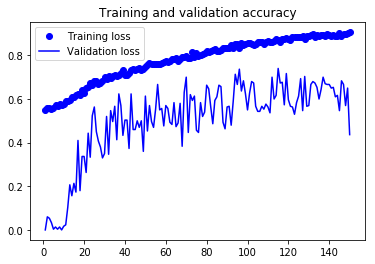

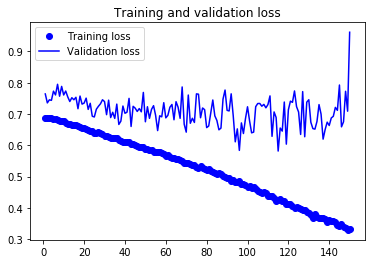

In [122]:
plot_acc_loss(history150)

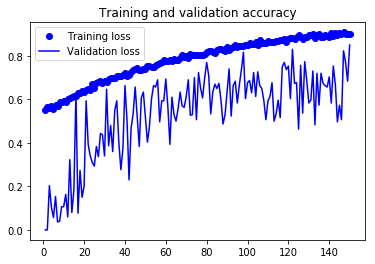

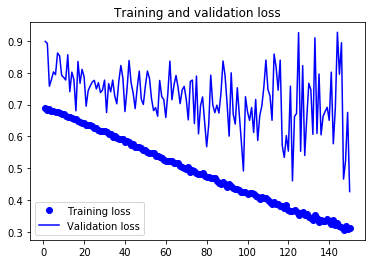

In [123]:
plot_acc_loss(history)

In [124]:
path_labels_test = r'D:\Machine Learning\Datasets\PAN 18 Author Profiling\pan18-author-profiling-test-2018-03-20'

labels_test = pd.read_csv(os.path.join(path_labels_test,'en.txt'),
                     sep=':::',header=None,
                     names=['identifier', 'gender'])

C:\Users\Simeon\Anaconda3\envs\First\lib\site-packages\ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


In [127]:
np.random.seed = 42

In [141]:
y_test = le.transform(labels_test.gender)

In [142]:
images_path_test = r'D:\Machine Learning\Datasets\PAN 18 Author Profiling\pan18-author-profiling-test-2018-03-20\en\photo'
vgg19_feat_test = img_feat_extractor_VGG19.feature_extraction(images_path_test,labels_test)

  1% (26 of 1900) |                      | Elapsed Time: 0:00:10 ETA:   0:11:08ERROR:root:cannot identify image file 'D:\\Machine Learning\\Datasets\\PAN 18 Author Profiling\\pan18-author-profiling-test-2018-03-20\\en\\photo\\3f4e19cc5d05d21ea1f6f33ce22cba07\\3f4e19cc5d05d21ea1f6f33ce22cba07.0.jpeg'
 21% (407 of 1900) |####                 | Elapsed Time: 0:02:35 ETA:   0:08:49ERROR:root:cannot identify image file 'D:\\Machine Learning\\Datasets\\PAN 18 Author Profiling\\pan18-author-profiling-test-2018-03-20\\en\\photo\\d5215f910f43b77372aba74bb7eb5424\\d5215f910f43b77372aba74bb7eb5424.1.jpeg'
 67% (1275 of 1900) |#############       | Elapsed Time: 0:07:50 ETA:   0:03:34ERROR:root:cannot identify image file 'D:\\Machine Learning\\Datasets\\PAN 18 Author Profiling\\pan18-author-profiling-test-2018-03-20\\en\\photo\\401ab80d3c0577e533904f2e0c174997\\401ab80d3c0577e533904f2e0c174997.6.jpeg'
100% (1900 of 1900) |####################| Elapsed Time: 0:11:35 Time:  0:11:35


In [143]:
vgg19_feat_test.shape

(1900, 10, 6, 6, 512)

In [144]:
vgg19_feat_test = vgg19_feat_test.reshape(vgg19_feat_test.shape[0],
                                          vgg19_feat_test.shape[1],-1)

In [145]:
y_pred = model.predict_classes(vgg19_feat_test)
accuracy_score(y_pred, y_test)

0.7157894736842105

In [139]:
model.save('vgg19-base-Dense4-Gru6.h5')

In [155]:
y_pred.reshape(-1).shape

(1900,)

In [157]:
img_pred = pd.DataFrame.from_dict({'identifier':labels_test.identifier.values, 'img_pred':y_pred.reshape(-1)})

In [158]:
img_pred.to_csv('img_pred_vgg19-base-Dense4-Gru6.csv', index='identifier')